In [28]:
from typing import List, Tuple, Optional

import os
import logging
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm import tqdm
from karateclub import Graph2Vec

from master_thesis.utils import LOGLEVEL_MAP
from master_thesis.classification_models import *
from master_thesis.tools.data import  load_np_data, Preprocessing
from master_thesis.tools.plots import plot_sample_networks, plot_weight_histogram

logging.basicConfig(level=LOGLEVEL_MAP["INFO"])

SEED = 42
K_FOLDS = 10

# === Scale Free Synthetic Dataset ===
NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/Synthetic/ScaleFreeBias/networks"
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/Synthetic/ScaleFreeEasy/networks"

# === Real World Stroke Split Dataset ===
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicksFC/networks"
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicksGC/networks"
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicksRCC/networks"
# NETWORKS_DIR_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicksUnidirRCC/networks"

# Load dataset

In [33]:
# Load raw numpy networks
X_raw, y_raw = load_np_data(NETWORKS_DIR_PATH)

# # Subtract control mean
# verbose_control_mean = X_raw[y_raw == 0].mean(axis=0)
# X_raw = X_raw - verbose_control_mean

# Preprocess data
X_verbose, y_verbose = Preprocessing(
    undirected=False,
    # connection_weight_threshold=(0.6, -0.6)
)(X_raw, y_raw)

# Print shapes
print(len(X_verbose), len(X_verbose))

1000 1000


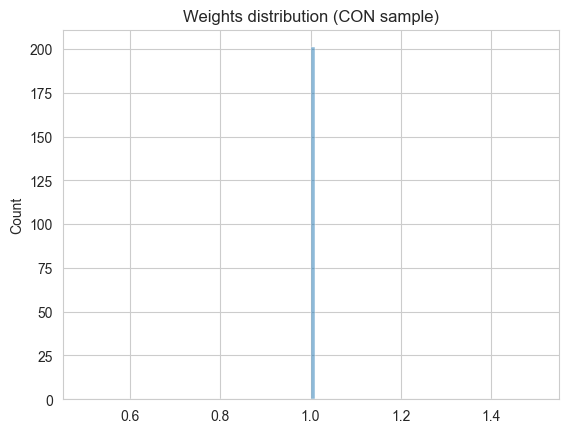

Ratio of edges to the full graph: 0.040606060606060604


In [34]:
idx = 5
plot_weight_histogram(X_verbose[idx], y_verbose[idx])
print(f"Ratio of edges to the full graph: {len(X_verbose[idx].edges) / (50 * 99)}")

### Plot sample class members

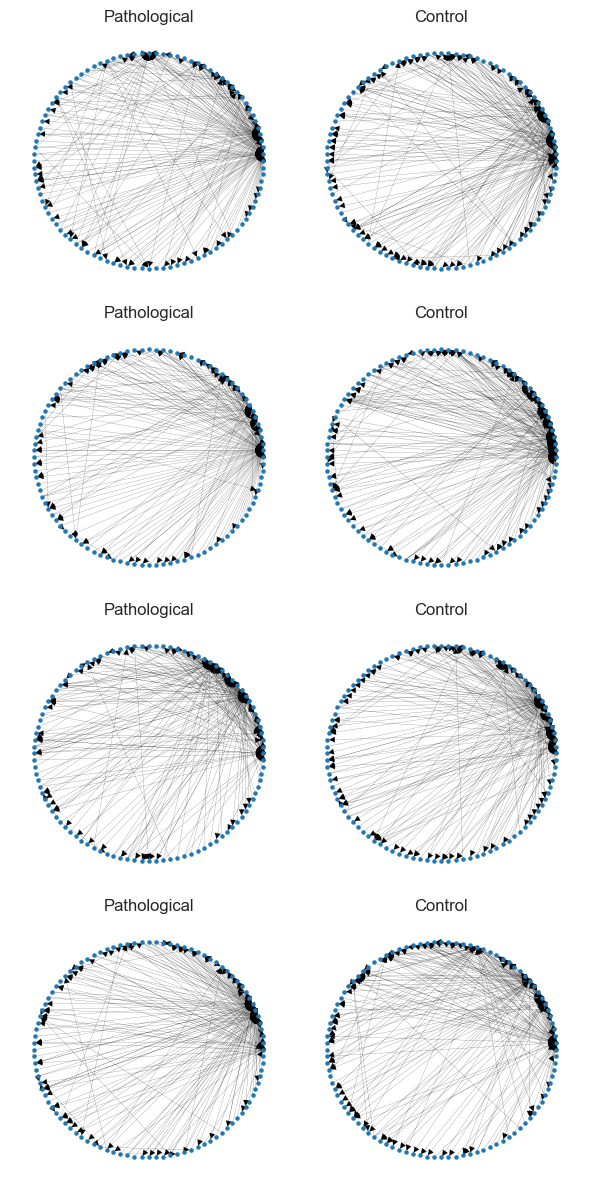

In [35]:
# Plot sample networks
plot_sample_networks(X_verbose, y_verbose, rows=4)

## Embedd networks (optionally)

In [27]:
# X_control_mean = X_raw[y_raw == 0].mean(axis=0)
# X_raw = X_raw - X_control_mean
# X, y = Preprocessing(
#     undirected=False,
#     connection_weight_threshold=(0.6, -0.6)
# )(X_raw, y_raw)


# graph2vec = Graph2Vec(dimensions=32, wl_iterations=2, epochs=200, seed=SEED, workers=1)
# graph2vec.fit(X)
# X = graph2vec.get_embedding()

# Pipe through the LDP model

## Leave-one-out cross-validation

In [20]:
# # Define accumulator lists
# y_gold_train_acc, y_hat_train_acc = [], []
# y_gold_test_acc, y_hat_test_acc = [], []

# # Define k-fold cross-validation
# kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
# for i, (train_index, test_index) in tqdm(enumerate(kfold.split(X)), total=K_FOLDS, desc="Cross-validation"):

#     # Split data
#     X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
#     y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

#     # # Train model (Graph2Vec)
#     # model = VectorModel()
#     # model.fit(X_train, y_train)

#     # Train model (LTP)
#     model = LTPModel(log_degree=True)
#     model.fit(X_train, y_train)

#     # Predict
#     y_hat_train = model.predict(X_train)
#     y_hat_train_acc.append(y_hat_train)
#     y_gold_train_acc.append(y_train)

#     y_hat_test = model.predict(X_test)
#     y_hat_test_acc.append(y_hat_test)
#     y_gold_test_acc.append(y_test)

# # Concatenate lists
# y_hat_train = np.concatenate(y_hat_train_acc)
# y_gold_train = np.concatenate(y_gold_train_acc)

# y_hat_test = np.concatenate(y_hat_test_acc)
# y_gold_test = np.concatenate(y_gold_test_acc)

Cross-validation: 100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


In [21]:
# # Evaluate classification
# print("=== Evaluating model on train data ===")
# print(BaseModel.evaluate(y_gold_train, y_hat_train, save_path="ltp_cm_train.png"))

# print("=== Evaluating model on test data ====")
# print(BaseModel.evaluate(y_gold_test, y_hat_test, save_path="ltp_cm_test.png"))

=== Evaluating model on train data ===
Accuracy:  1.00
Recall:    1.00
Precision: 1.00
f1 score:  1.00
AUC score: 1.00

=== Evaluating model on test data ====
Accuracy:  0.84
Recall:    0.99
Precision: 0.85
f1 score:  0.91
AUC score: 0.50



<Figure size 640x480 with 0 Axes>

## Holdout

In [36]:
# import warnings
# warnings.filterwarnings('ignore')

holdout_size = 0.2
holdout_size = int(holdout_size * len(X_raw))

# Shuffle data
idx = np.arange(len(X_raw))
np.random.shuffle(idx)
X_raw = np.array([X_raw[i] for i in idx])
y_raw = np.array([y_raw[i] for i in idx])

# Split data
X_train, X_test = X_raw[:-holdout_size], X_raw[-holdout_size:]
y_train, y_test = y_raw[:-holdout_size], y_raw[-holdout_size:]

# Subtraction of control mean
train_control_mean = X_train[y_train == 0].mean(axis=0)
X_train = X_train - train_control_mean
X_test = X_test - train_control_mean

# Preprocessing
X_train, y_train = Preprocessing(
    undirected=False,
    # connection_weight_threshold=(0.6, -0.6)
)(X_train, y_train)
X_test, y_test = Preprocessing(
    undirected=False,
    # connection_weight_threshold=(0.6, -0.6)
)(X_test, y_test)

In [ ]:
# Train model
model = GCNModel(learning_rate=0.005, epochs=100, print_every=20, ldp_features=True)
model.fit(X_train, y_train)

In [13]:
print("=== Evaluating model on train data ===")
y_hat_train = model.predict(X_train)
print(BaseModel.evaluate(np.array(y_train), y_hat_train, save_path="gcn_cm_train.png"))

print("=== Evaluating model on test data ====")
y_hat_test = model.predict(X_test)
print(BaseModel.evaluate(y_test, y_hat_test, save_path="gcn_cm_test.png"))

INFO:root:Loaded model from epoch 97 with validation metric 0.8672


=== Evaluating model on train data ===


INFO:root:Loaded model from epoch 97 with validation metric 0.8672


Accuracy:  0.72
Recall:    0.73
Precision: 0.92
f1 score:  0.81
AUC score: 0.70

=== Evaluating model on test data ====
Accuracy:  0.70
Recall:    0.71
Precision: 0.93
f1 score:  0.80
AUC score: 0.67



<Figure size 640x480 with 0 Axes>